# BGS Morphological Properties

The goal of this notebook is to quantify the average morphological properties of the BGS sample. Specifically, the DESI-Data simulations require knowledge of the mean half-light radii of the bulge and disk components of the sample, as well as the average light fraction between the two components.

These measurements require a detailed study by the BGS, Targeting, and Galaxy & Quasar Physics Working Groups. However, as a quick hack we can use the expectation that the BGS galaxy sample will have very similar properties as the SDSS/Main sample.  (BGS will target galaxies to r=20, reaching a median redshift of z=0.2, whereas SDSS/Main targeted galaxies to r=17.7 and reached a median redshift of z=0.1.  Although there exists a small amount of luminosity evolution and evolution in the size-mass relation between these two epochs, the amount of evolution is significantly smaller than the scatter in galaxy properties at fixed redshift and stellar mass.)

Fortunately, A. Meert and collaborators have carried out a detailed 2D morphological analysis of galaxies in the SDSS/Main sample and publicly released their [catalog](http://alan-meert-website-aws.s3-website-us-east-1.amazonaws.com/fit_catalog/download/index.html).  Some of the relevant papers include:

* [Vikram et al. 2010, PyMorph: Automated Galaxy Structural Parameter Estimation using Python](https://arxiv.org/abs/1007.4965)
* [Meert et al. 2013, Simulations of single- and two-component galaxy decompositions for spectroscopically selected galaxies from the SDSS](http://adsabs.harvard.edu/abs/2013MNRAS.433.1344M)
* [Meert et al. 2015, A catalogue of 2D photometric decompositions in the SDSS-DR7 spectroscopic main galaxy sample: preferred models and systematics](http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M)
* [Meert et al. 2016, A catalogue of 2D photometric decompositions in the SDSS-DR7 spectroscopic main galaxy sample: extension to g and i bands](http://adsabs.harvard.edu/abs/2016MNRAS.455.2440M)

Here we focus on the fits to the *g*-band SDSS imaging, as this will most closely resemble the *r*-band selection of the BGS sample.

## Imports and paths--

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import fitsio
from astropy.table import Table
from corner import corner

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [3]:
basicdir = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec', 'basic-catalog', 'v2')
adddir = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec', 'additional-catalogs')

## Read the parent CAST catalog.
Read the parent SDSS (CAST) catalog which defines the sample.

In [4]:
castfile = os.path.join(basicdir, 'UPenn_PhotDec_CAST.fits')
castinfo = fitsio.FITS(castfile)
castinfo[1]


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_CAST.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    galcount            i4  
    objid               i8  
    SDSSIAU            S24  
    badflag             i4  
    nchild              i2  
    mode                i2  
    run                 i2  
    rerun               i2  
    camCol              i2  
    field               i2  
    obj                 i2  
    stripe              i4  
    startmu             i4  
    specobjid           i8  
    plate               i2  
    mjd                 i4  
    fiberid             i2  
    ra                  f4  
    dec                 f4  
    z                   f4  
    veldisp             f4  
    veldispErr          f4  
    eclass              f4  
    p_el_debiased       f4  
    p_cs_debiased       f4  
    spiral              i4  
    elliptical          i4  
    uncertain           i4  

In [5]:
allcast = castinfo[1].read()

## Read the g-band model fitting results and select a "good" sample.

Read the *g*-band model fitting results and select a clean sample using the "finalflag" bit (see Section 2.2 of the data_tables.pdf documentation).

In [6]:
thisband = 'gband'

In [7]:
def photdec_select(finalflag, bit):
    """Select subsets of the catalog using the finalflag bitmask.

     1 - good bulge-only galaxy
     4 - good disk-only galaxy
    10 - good two-component fit (logical_or of flags 11, 12, and 13)
    20 - bad total magnitude and size

    """
    return finalflag & np.power(2, bit) != 0

In [8]:
def select_meert(modelcat, onecomp=False, twocomp=False):
    """Select various (good) subsets of galaxies.
    
    Args:
      modelcat: 'UPenn_PhotDec_Models_[g,r,i]band.fits' catalog.
      onecomp (bool): galaxies fitted with single-Sersic model.
      twocomp (bool): galaxies fitted with Sersic-exponential model.
    
    Notes:
      * Flag 10 is a logical_or of 11, 12, 13.
      * Flag 1, 4, and 10 are mutually exclusive.
      * If Flag 1 or 4 are set then n_disk,r_disk are -999.
    
    """
    finalflag = modelcat['finalflag']
    smalln = modelcat['n_bulge'] < 8
    goodr = modelcat['r_bulge'] > 0 # Moustakas hack

    two = photdec_select(finalflag, 10)
    two = np.logical_and( two, smalln )
    two = np.logical_and( two, goodr )

    if twocomp:
        return two

    one = np.logical_or( photdec_select(finalflag, 1), photdec_select(finalflag, 4) )
    one = np.logical_and( one, smalln )
    if onecomp:
        return one

    both = np.logical_or( one, two )
    
    return both

In [9]:
measfile = os.path.join(basicdir, 'UPenn_PhotDec_nonParam_{}.fits'.format(thisband))
measinfo = fitsio.FITS(measfile)
fitfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
fitinfo = fitsio.FITS(fitfile)    
print(measinfo[1], fitinfo[1])

_fit = fitinfo[1].read(columns=['finalflag', 'n_bulge', 'r_bulge'])
good = select_meert(_fit)
goodindx = np.where(good)[0]

nobj = len(goodindx)
print('Selected {}/{} good targets.'.format(nobj, len(_fit)))


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_nonParam_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    SexMag              f4  
    SexMag_Err          f4  
    SexHrad             f4  
    SexSky              f4  
    num_targets         i2  
    num_neighborfit     i2  
    AperRad             f4  
    C                   f4  
    C_err               f4  
    A                   f4  
    A_err               f4  
    S                   f4  
    S_err               f4  
    G                   f4  
    M20                 f4  
    extinction          f4  
    dismod              f4  
    kpc_per_arcsec      f4  
    Vmax                f4  
    SN                  f4  
    kcorr               f4   
  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_Models_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    m_tot               f4  
    m_aper              f4  
 

In [10]:
fit, meas = [], []
fitfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
measfile = os.path.join(basicdir, 'UPenn_PhotDec_NonParam_{}.fits'.format(thisband))
gfit = fitsio.read(fitfile, ext=1, rows=goodindx)
gmeas = fitsio.read(measfile, ext=1, rows=goodindx)
cast = allcast[goodindx]

#### Identify the subset of galaxies with good 1- and 2-component fits.

In [11]:
one = select_meert(gfit, onecomp=True)
two = select_meert(gfit, twocomp=True)

## Generate some plots.

In [12]:
print('g-band range = {:.3f} - {:.3f}'.format(gfit['m_tot'].min(), gfit['m_tot'].max()))
print('Redshift range = {:.4f} - {:.4f}'.format(cast['z'].min(), cast['z'].max()))

g-band range = 13.311 - 21.241
Redshift range = 0.0050 - 0.8436


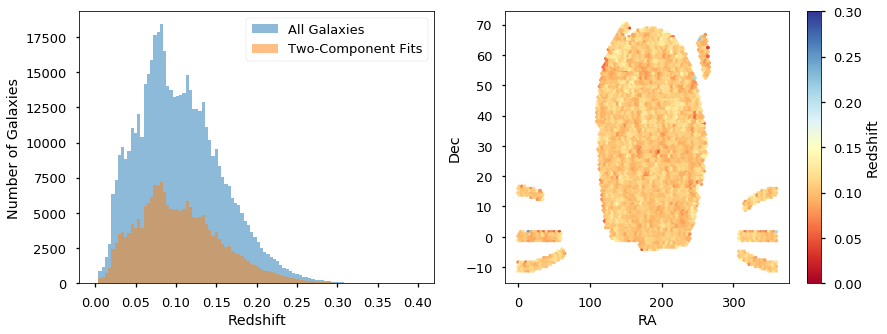

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
_ = ax1.hist(cast['z'], bins=100, range=(0, 0.4), alpha=0.5, label='All Galaxies')
_ = ax1.hist(cast['z'][two], bins=100, range=(0, 0.4), alpha=0.5, label='Two-Component Fits')
ax1.legend(loc='upper right')

ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of Galaxies')

hb = ax2.hexbin(cast['ra'], cast['dec'], C=cast['z'], vmin=0, vmax=0.3,
                  cmap=plt.cm.get_cmap('RdYlBu'))
cb = plt.colorbar(hb)
cb.set_label('Redshift')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')

Quantiles:
[(0.25, 17.383899688720703), (0.5, 17.959699630737305), (0.75, 18.37809944152832)]
Quantiles:
[(0.25, 0.36465901136398315), (0.5, 0.47657701373100281), (0.75, 0.58791100978851318)]
Quantiles:
[(0.25, 1.1275999546051025), (0.5, 2.265700101852417), (0.75, 3.6012001037597656)]
Quantiles:
[(0.25, -0.077117852866649628), (0.5, 0.11091277003288269), (0.75, 0.30745750665664673)]
Quantiles:
[(0.25, 0.54198336601257324), (0.5, 0.67016416788101196), (0.75, 0.8160204291343689)]


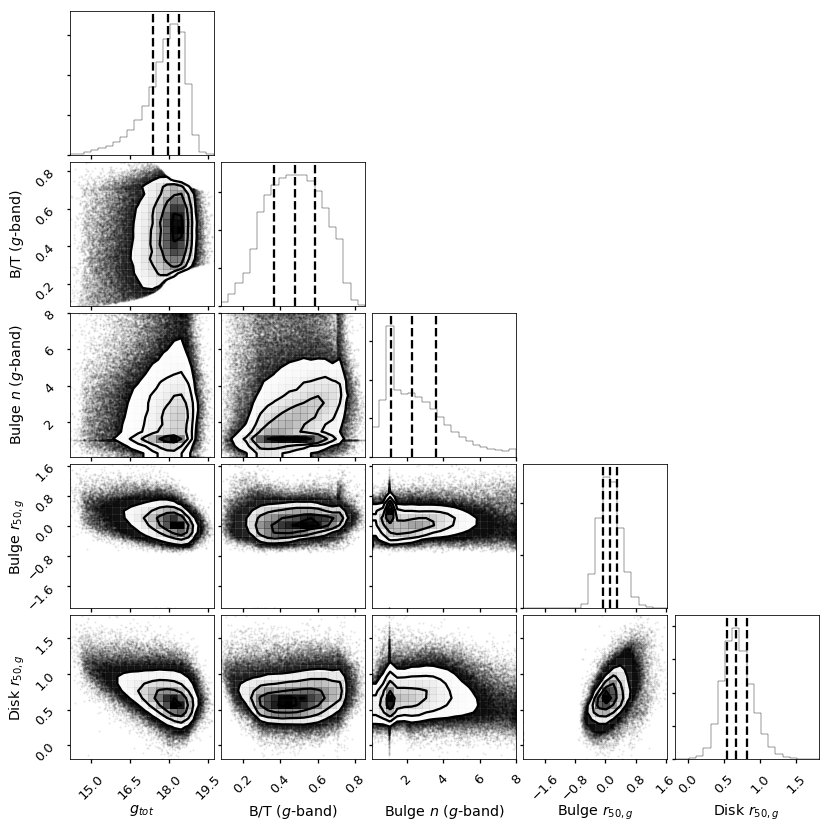

In [14]:
labels = [r'$g_{tot}$', r'B/T ($g$-band)', r'Bulge $n$ ($g$-band)', 
          r'Bulge $r_{50, g}$', r'Disk $r_{50, g}$']
data = np.array([ 
    gfit['m_tot'][two],
    gfit['BT'][two],
    gfit['n_bulge'][two],
    np.log10(gfit['r_bulge'][two]),
    np.log10(gfit['r_disk'][two])
]).T
data.shape

_ = corner(data, quantiles=[0.25, 0.50, 0.75], labels=labels,
           range=np.repeat(0.9999, len(labels)), verbose=True)

## Conclusions--

The corner plots above demonstrate -- in so far as this sample is representative of the BGS targets -- that the median (and interquartile) morphological properties are:

* B/T (bulge-to-total ratio): 0.48 (0.36 - 0.59).
* Bulge Sersic n: 2.27 (1.12 - 3.60).
* log10 (Bulge Half-light radius): 0.11 (-0.077 - 0.307) arcsec
* log10 (Disk Half-light radius): 0.67 (0.54 - 0.82) arcsec